In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import cv2
import seaborn as sns
import glob
import xml.etree.ElementTree as ET
from PIL import Image
import os
import shutil
import json
from pathlib import Path

In [21]:
base_dir = "/Users/tim/Downloads/CV_dataset"  # For MAC
print(f"Dataset Folder found: {os.path.exists(base_dir)}")

ann_dir = os.path.join(base_dir, "ann")
img_dir = os.path.join(base_dir, "img")


ann_count = len(glob.glob(os.path.join(ann_dir, "*.txt")))
img_count = len(glob.glob(os.path.join(img_dir, "*.png")) +
             glob.glob(os.path.join(img_dir, "*.jpg")) +
             glob.glob(os.path.join(img_dir, "*.jpeg")))

print(f"Images found: {img_count}")
print(f"Annotations found: {ann_count}")

Dataset Folder found: True
Images found: 5711
Annotations found: 5711


In [28]:
def visualize_yolo_masks(num_samples=4):
    """Visualize images with YOLO segmentation masks"""

    # Get ALL image files (PNG, JPG, JPEG)
    image_files = (glob.glob(os.path.join(img_dir, "*.png")) +
                   glob.glob(os.path.join(img_dir, "*.jpg")) +
                   glob.glob(os.path.join(img_dir, "*.jpeg")))

    if not image_files:
        print(f"❌ No image files found in {img_dir}")
        return

    print(f"Found {len(image_files)} images")

    # Show first few samples
    for i, image_file in enumerate(image_files[:num_samples]):
        # Load image
        image = cv2.imread(image_file)
        if image is None:
            print(f"❌ Could not load image: {image_file}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width = image.shape[:2]

        # FIX: Keep the image extension in the annotation filename
        image_filename = os.path.basename(image_file)  # e.g., "softball-player-female-glove-163330.png"
        label_file = os.path.join(ann_dir, image_filename + ".txt")  # e.g., "softball-player-female-glove-163330.png.txt"

        print(f"Looking for: {os.path.basename(label_file)}")

        # Create a copy for drawing
        image_with_mask = image.copy()

        if os.path.exists(label_file):
            # Read YOLO segmentation annotations
            with open(label_file, 'r') as f:
                lines = f.readlines()

            print(f"✅ Sample {i+1}: {len(lines)} person(s) in {os.path.basename(image_file)}")

            for line in lines:
                parts = line.strip().split()
                if len(parts) < 6:
                    continue

                # Parse YOLO segmentation format
                class_id = int(parts[0])
                polygon_points = []

                # Parse polygon points (skip first 5 bbox values)
                for j in range(5, len(parts), 2):
                    if j + 1 < len(parts):
                        x = float(parts[j]) * width
                        y = float(parts[j + 1]) * height
                        polygon_points.append([x, y])

                # Draw polygon mask
                if len(polygon_points) > 2:
                    pts = np.array(polygon_points, np.int32)

                    # Create filled mask
                    mask = np.zeros((height, width), dtype=np.uint8)
                    cv2.fillPoly(mask, [pts], 255)

                    # Create colored overlay
                    overlay = image_with_mask.copy()
                    cv2.fillPoly(overlay, [pts], (255, 0, 0))  # Blue fill

                    # Blend overlay with original image
                    alpha = 0.3  # Transparency
                    image_with_mask = cv2.addWeighted(overlay, alpha, image_with_mask, 1 - alpha, 0)

                    # Draw polygon outline
                    cv2.polylines(image_with_mask, [pts], True, (0, 255, 0), 2)  # Green outline

                    # Draw bounding box
                    bbox_x = float(parts[1]) * width
                    bbox_y = float(parts[2]) * height
                    bbox_w = float(parts[3]) * width
                    bbox_h = float(parts[4]) * height

                    x1 = int(bbox_x - bbox_w / 2)
                    y1 = int(bbox_y - bbox_h / 2)
                    x2 = int(bbox_x + bbox_w / 2)
                    y2 = int(bbox_y + bbox_h / 2)

                    cv2.rectangle(image_with_mask, (x1, y1), (x2, y2), (255, 255, 0), 2)  # Cyan bbox

                    # Add label
                    cv2.putText(image_with_mask, f'Person {class_id}', (x1, y1 - 10),
                               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

        else:
            print(f"❌ No label file found: {label_file}")
            # Try alternative naming pattern
            alt_base_name = os.path.splitext(os.path.basename(image_file))[0]
            alt_label_file = os.path.join(ann_dir, alt_base_name + ".txt")
            if os.path.exists(alt_label_file):
                print(f"✅ Found with alternative name: {os.path.basename(alt_label_file)}")
            else:
                print(f"❌ Also not found: {os.path.basename(alt_label_file)}")
            image_with_mask = image

        # Display
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.title(f"Original: {os.path.basename(image_file)}")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(image_with_mask)
        plt.title(f"With Masks: {len(lines) if os.path.exists(label_file) else 0} person(s)")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Run it


Found 5711 images
Looking for: softball-player-female-glove-163330.png.txt
✅ Sample 1: 1 person(s) in softball-player-female-glove-163330.png


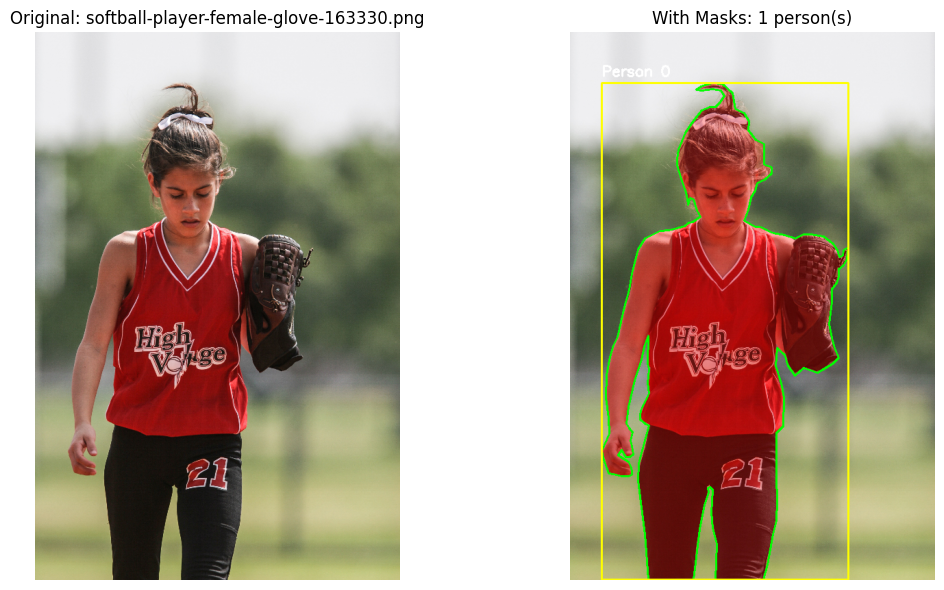

Looking for: nature-sunset-person-woman.png.txt
✅ Sample 2: 0 person(s) in nature-sunset-person-woman.png


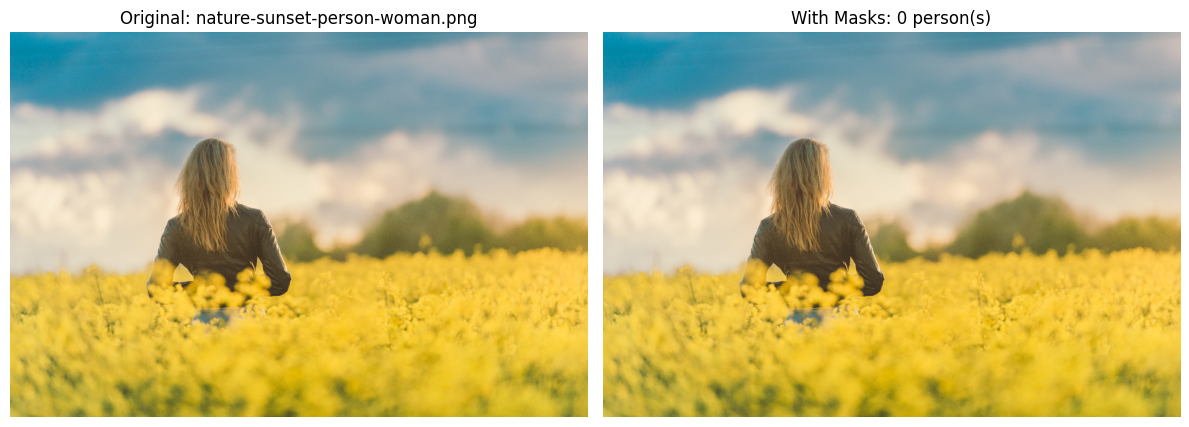

Looking for: pexels-photo-300968.png.txt
✅ Sample 3: 1 person(s) in pexels-photo-300968.png


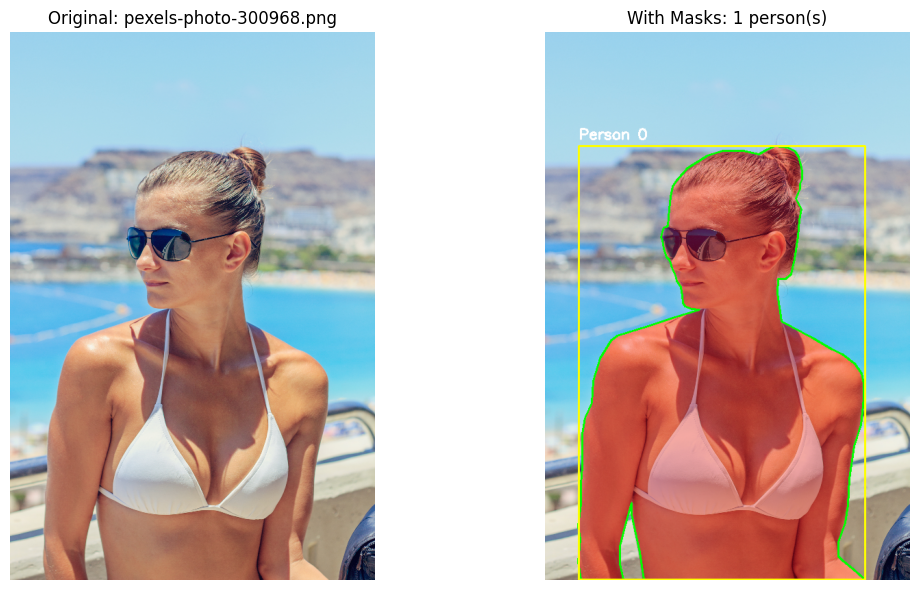

Looking for: pexels-photo-219593.png.txt
✅ Sample 4: 1 person(s) in pexels-photo-219593.png


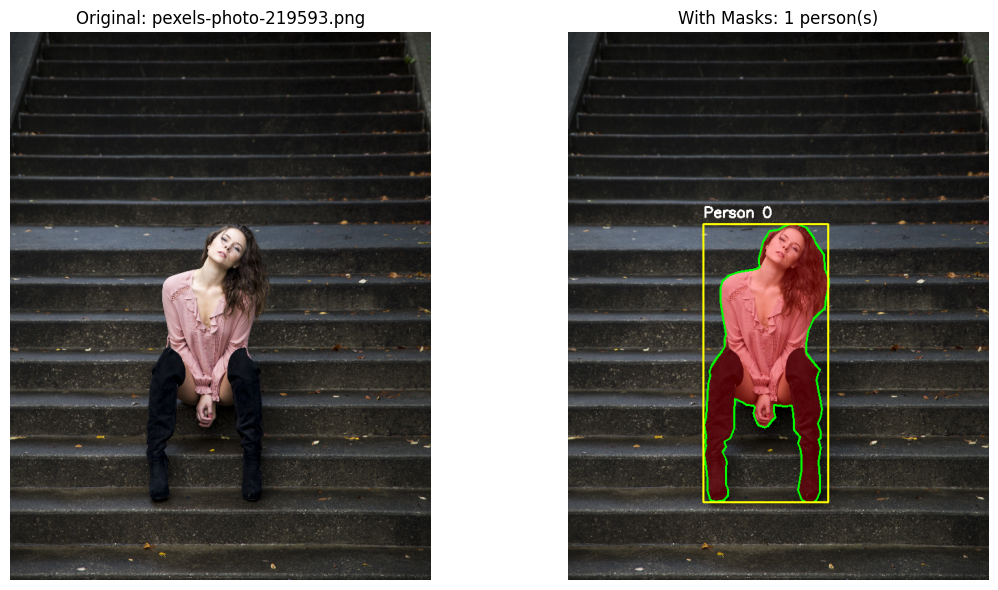

In [29]:
visualize_yolo_masks(4)